Link com banco de dados: https://www.kaggle.com/datasets/youssefaboelwafa/clustering-penguins-species?resource=download

Conexão com o google drive

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Pacotes utilizados

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo dos gráficos
sns.set(style="whitegrid")

Leitura dos dados

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Teste_de_Python/Pinguins/penguins.csv')
df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


1. Pré-processamento dos dados

In [7]:
# 1. Remover linhas com todos os valores NA
df = df.dropna(how='all')
df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
4,36.7,19.3,193.0,3450.0,FEMALE
5,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,FEMALE
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


In [8]:
# 2. Tratar a variável categórica (Sexo)
df['sex'] = df['sex'].map({'MALE': 1, 'FEMALE': 0})  # Transformar em numérico
df

<ipython-input-8-b5ffc0291ca6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = df['sex'].map({'MALE': 1, 'FEMALE': 0})  # Transformar em numérico


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,1.0
1,39.5,17.4,186.0,3800.0,0.0
2,40.3,18.0,195.0,3250.0,0.0
4,36.7,19.3,193.0,3450.0,0.0
5,39.3,20.6,190.0,3650.0,1.0
...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,0.0
340,46.8,14.3,215.0,4850.0,0.0
341,50.4,15.7,222.0,5750.0,1.0
342,45.2,14.8,212.0,5200.0,0.0


In [13]:
# 3. Separar as variáveis contínuas
continuous_vars = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_vars = ['sex']
completa_vars = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g','sex']

In [14]:
# Selecionar apenas as colunas contínuas e categóricas
data_continuous = df[continuous_vars]
data_categorical = df[categorical_vars]

In [ ]:
# Padronizar as variáveis contínuas
scaler = StandardScaler()
data_continuous_scaled = scaler.fit_transform(data_continuous)
data_continuous_scaled = pd.DataFrame(data_continuous_scaled, columns=continuous_vars)
data_continuous_scaled

In [44]:
# Padronizar as variáveis como um todo
scaler = StandardScaler()
df_completa = scaler.fit_transform(df)
df_completa = pd.DataFrame(df_completa, columns=completa_vars)
df_completa = df_completa.dropna(subset=['sex'])
df_completa

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.884499,0.785449,-0.126893,-0.564142,0.988095
1,-0.811126,0.126188,-0.107675,-0.501703,-1.012049
2,-0.664380,0.430462,-0.073083,-1.188532,-1.012049
3,-1.324737,1.089724,-0.080771,-0.938776,-1.012049
4,-0.847812,1.748985,-0.092301,-0.689020,0.988095
...,...,...,...,...,...
337,0.601305,-1.750171,-0.000056,0.903175,-1.012049
338,0.527932,-1.445897,0.003787,0.809516,-1.012049
339,1.188289,-0.735923,0.030692,1.933419,0.988095
340,0.234440,-1.192335,-0.007743,1.246590,-1.012049


**Funções de Visualização**

In [32]:
# Função para plotar os gráficos
def plot_clusters(data, labels, title):
    """
    Função para visualizar clusters em 2D usando as duas primeiras variáveis.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=labels, palette='viridis')
    plt.title(title)
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.legend(title='Cluster')
    plt.show()

# Função para visualização
def plot_dendrogram(data, method='ward', title='Dendrograma'):
    """
    Função para plotar dendrograma para Hierarchical Clustering.
    """
    linked = linkage(data, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.title(title)
    plt.xlabel('Amostras')
    plt.ylabel('Distância')
    plt.show()

**Clusteriazação apenas com as variáveis contínuas**

In [35]:
# Preparar os dados sem a variável categórica
X_without_cat = data_continuous_scaled.values

**K-Means**

In [ ]:
# Determinar o número ideal de clusters usando o método do cotovelo para K-means
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_without_cat)
    inertia.append(kmeans.inertia_)

# Plotar o método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para K-means (Sem Variável Categórica)')
plt.show()

In [ ]:
# Suponha que o número ideal de clusters seja 3
kmeans_without_cat = KMeans(n_clusters=3, random_state=42)
clusters_kmeans_without_cat = kmeans_without_cat.fit_predict(X_without_cat)

# Visualizar os clusters (usando as duas primeiras variáveis contínuas padronizadas)
plot_clusters(data_continuous_scaled, clusters_kmeans_without_cat, "K-means sem Variável Categórica")

**Hierarquical Clustering**

In [ ]:
# Hierarchical Clustering sem a variável categórica
linked = linkage(X_without_cat, method='ward')

# Plotar dendrograma
plot_dendrogram(X_without_cat, method='ward', title='Dendrograma para Hierarchical Clustering (Sem Variável Categórica)')

In [ ]:
# Definir clusters (supondo 3 clusters)
clusters_hierarchical_without_cat = fcluster(linked, 3, criterion='maxclust')

# Visualizar os clusters
plot_clusters(data_continuous_scaled, clusters_hierarchical_without_cat, "Hierarchical Clustering sem Variável Categórica")

**Clusteriazação apenas com todas as variáveis padronizadas**

In [45]:
# Preparar os dados com a variável categórica
X_with_cat = df_completa.values

**K-Means**

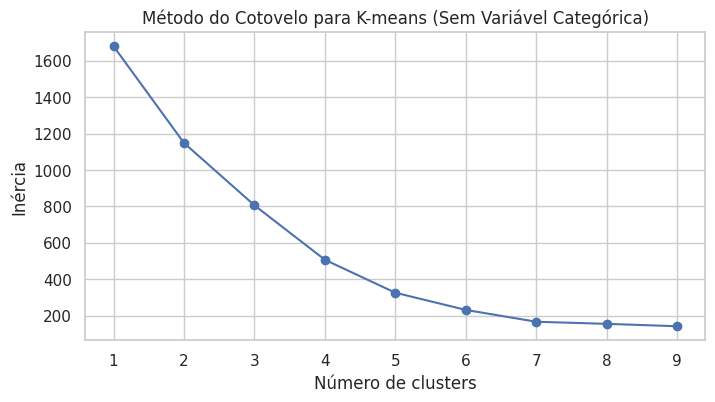

In [46]:
# Determinar o número ideal de clusters usando o método do cotovelo para K-means
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_with_cat)
    inertia.append(kmeans.inertia_)

# Plotar o método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para K-means (Sem Variável Categórica)')
plt.show()

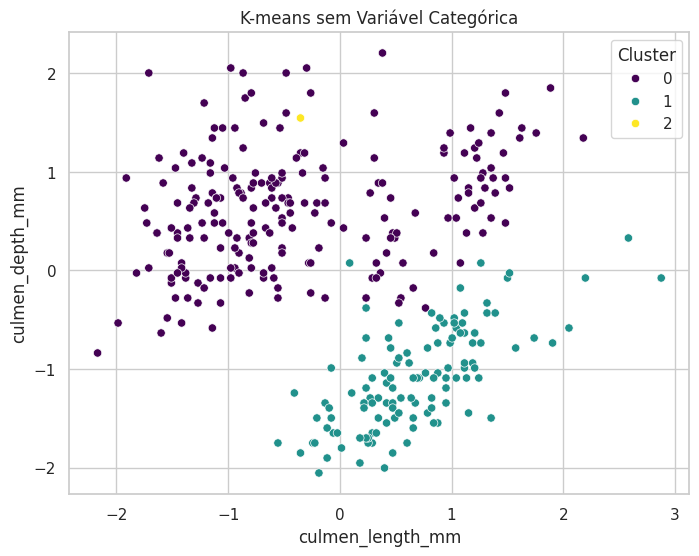

In [49]:
# Suponha que o número ideal de clusters seja 3
kmeans_with_cat = KMeans(n_clusters=3, random_state=42)
clusters_kmeans_with_cat = kmeans_with_cat.fit_predict(X_with_cat)

# Visualizar os clusters (usando as duas primeiras variáveis contínuas padronizadas)
plot_clusters(df_completa, clusters_kmeans_with_cat, "K-means sem Variável Categórica")

**Hierarquical Clustering**

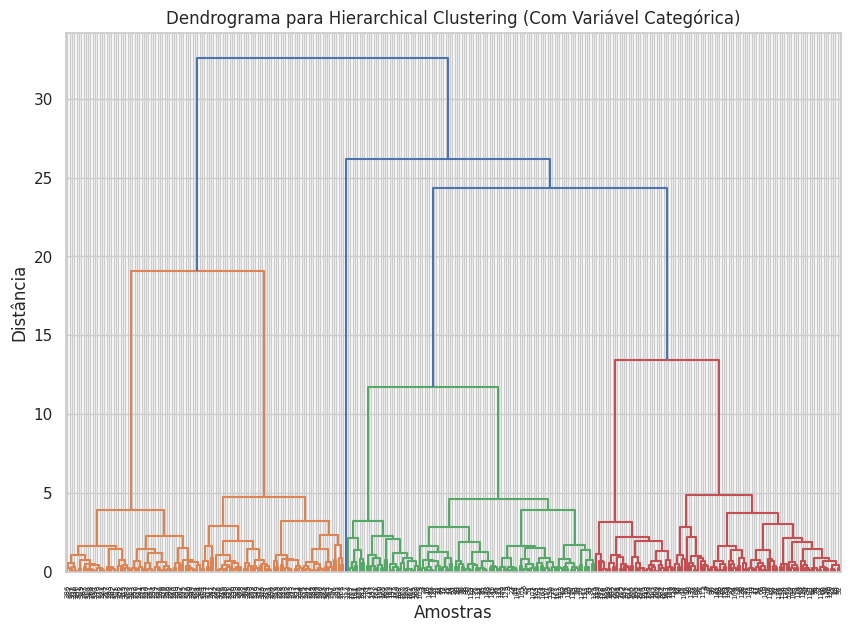

In [50]:
# Hierarchical Clustering sem a variável categórica
linked = linkage(X_with_cat, method='ward')

# Plotar dendrograma
plot_dendrogram(X_with_cat, method='ward', title='Dendrograma para Hierarchical Clustering (Com Variável Categórica)')

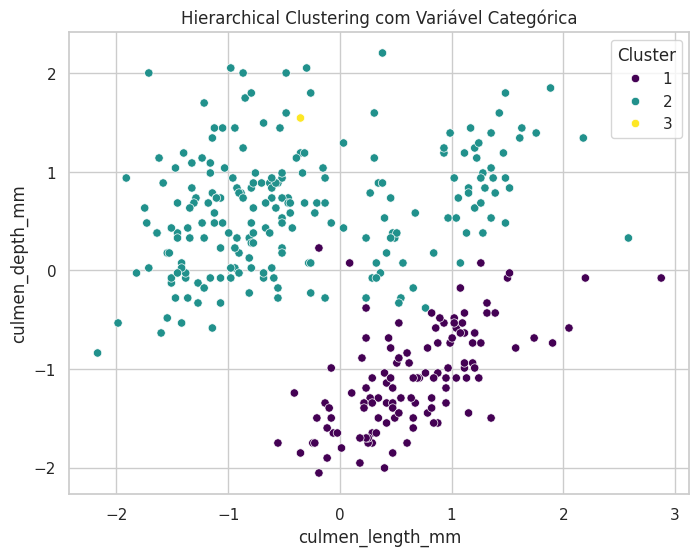

In [52]:
# Definir clusters (supondo 3 clusters)
clusters_hierarchical_with_cat = fcluster(linked, 3, criterion='maxclust')

# Visualizar os clusters
plot_clusters(df_completa, clusters_hierarchical_with_cat, "Hierarchical Clustering com Variável Categórica")